In [1]:
# Linear Regression model
import sys
import os
sys.path.append(os.path.abspath('..')) # adding path for packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import utils.data_preprocessing as dp
import numpy as np

In [2]:
data_X = dp.loadMatFile('../../Datasets/20110607S2_EEGandECoG_Su_Oosugi_ECoG128-EEG18/20110607S2_EEGECoG_Su_Oosugi_ECoG128-EEG18_mat/ECoG05_anesthesia.mat')
data_y = dp.loadMatFile('../../Datasets/20110607S2_EEGandECoG_Su_Oosugi_ECoG128-EEG18/20110607S2_EEGECoG_Su_Oosugi_ECoG128-EEG18_mat/ECoG05_anesthesia.mat')
X = data_X[1]
y = data_y[1]
print(X.shape)
print(y.shape)

(129, 319234)
(129, 319234)


In [3]:
# downsample if mismatch in size of datasets
if data_X[1].shape[1] != data_y[1].shape[1]:
    # gaussian normalization
    if X.shape[1] > y.shape[1]:
        X = dp.downsample_data(X, y.shape[1])
    elif X.shape[1] < y.shape[1]:
        y = dp.downsample_data(y, X.shape[1])

In [4]:
X = X.T
y = y.T

# Split data into training, validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Normalize X
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

Train shapes: (255387, 129) (255387, 129)
Validation shapes: (31923, 129) (31923, 129)
Test shapes: (31924, 129) (31924, 129)


In [5]:
# simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(64, output_size)

    def forward(self, x):
        x1 = self.linear(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [6]:
# instantiate the model
input_size = X_tensor.size(1)  # 129 (ecog)
output_size = y_tensor.size(1)  # 19 (eeg)
model = LinearRegressionModel(input_size, output_size)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# create DataLoader for batch processing
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32)

In [7]:
# Training loop RAW DATA
num_epochs = 200
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss and mse for the epoch
    epoch_loss /= len(dataloader)

    # Append the loss values to the lists
    loss_values.append(epoch_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

: 

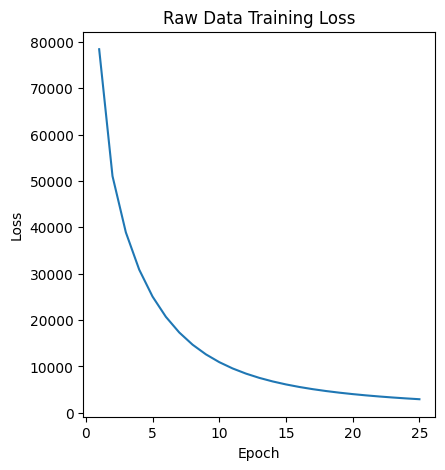

In [ ]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 25 + 1), loss_values[:25], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Raw Data Training Loss')
plt.show()

In [ ]:
# Evaluate on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Make predictions on validation set
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor)
    val_loss = criterion(y_pred, y_val_tensor).item()
    
    y_pred_np = y_pred.numpy().T
    y_val_np = y_val_tensor.numpy().T
    
    corc = np.corrcoef(y_pred_np, y_val_np)
    corc = (corc + 1) / 2
    # average across rows
    electrode_corc = np.mean(corc, axis=1)
    print("accuracy per electrode: ")
    print(electrode_corc)
    overall_acc = np.mean(corc)
    
print(f"Test Error: \n Accuracy: {overall_acc:>0.4f}, Avg loss: {val_loss:>8f} \n")

accuracy per electrode: 
[0.55953109 0.57452018 0.55086132 0.50097699 0.50673169 0.55061067
 0.55739988 0.57605099 0.57924366 0.58106133 0.5477858  0.51370487
 0.53409575 0.5613393  0.49163903 0.57980701 0.5570603  0.56007093
 0.5502825  0.51585206 0.54510681 0.55478943 0.57219319 0.57417438
 0.52121344 0.55104759 0.54988225 0.54010694 0.53579907 0.51709559
 0.51924759 0.534409   0.56543193 0.57364825 0.56707414 0.55701108
 0.54936972 0.54571832 0.53086643 0.51948469 0.50434205 0.50457988
 0.58370356 0.58591844 0.55170246 0.55381283 0.55978006 0.579799
 0.5721594  0.5234315  0.5111306  0.47063013 0.44864902 0.53042176
 0.5502763  0.58906197 0.59978448 0.60084997 0.61729103 0.51822002
 0.48167901 0.47130841 0.52451841 0.54784622 0.5969945  0.59762799
 0.57109527 0.55567013 0.56793403 0.61242154 0.59647985 0.58413037
 0.58683547 0.62581467 0.6203849  0.57129901 0.56661757 0.57933679
 0.57624935 0.58230129 0.56864225 0.56670986 0.56561664 0.57918149
 0.57425776 0.57188645 0.57297574 0.582

In [ ]:
# instantiate the model
input_size = X_tensor.size(1)  # 129 (ecog)
output_size = y_tensor.size(1)  # 19 (eeg)
preprocess_model = LinearRegressionModel(input_size, output_size)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [ ]:
# possible hyperparameters
low_bound = 0.5
high_bound = 45
sampling_rate = 1000

# bandwidth_butterworth_filter
X_train_filtered = dp.butter_bandpass_filter(X_train.T, low_bound, high_bound, sampling_rate)
X_val_filtered = dp.butter_bandpass_filter(X_val.T, low_bound, high_bound, sampling_rate)

# PCA whitening
X_train_w = dp.whitening(X_train_filtered.T)
X_val_w = dp.whitening(X_val_filtered.T)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train_w.T, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

print(X_tensor.size(1))
print(y_tensor.size(1))
# create DataLoader for batch processing
processed_dataset = TensorDataset(X_tensor, y_tensor)
processed_dataloader = DataLoader(dataset, batch_size=64)



[1.87511069e+00 1.49258995e+00 8.56907749e-01 7.59270353e-01
 5.68381522e-01 4.63313516e-01 3.53629696e-01 3.45063965e-01
 2.65643542e-01 2.42808338e-01 2.33792515e-01 2.12604382e-01
 1.71490551e-01 1.64405687e-01 1.47924839e-01 1.40953299e-01
 1.32663306e-01 1.29553980e-01 1.21635250e-01 1.09417489e-01
 1.05024152e-01 9.84125327e-02 9.63501864e-02 9.56979955e-02
 9.09594606e-02 8.10255265e-02 7.92251063e-02 7.71441853e-02
 7.49755210e-02 7.32872664e-02 7.18215437e-02 6.96420091e-02
 6.49165351e-02 6.37500864e-02 6.10230292e-02 5.91570113e-02
 5.73297882e-02 5.42031964e-02 5.18710896e-02 5.02916567e-02
 5.00192155e-02 4.90853257e-02 4.53569697e-02 4.30430481e-02
 4.27367611e-02 4.04374529e-02 3.89731813e-02 3.86816923e-02
 3.68341345e-02 3.58844541e-02 3.54933260e-02 3.42850720e-02
 3.34969868e-02 3.15330596e-02 3.05883416e-02 3.00441922e-02
 2.92446962e-02 2.89706865e-02 2.79564350e-02 2.72860857e-02
 2.65413136e-02 2.56698563e-02 2.44100310e-02 2.37859257e-02
 2.33641740e-02 2.249405

In [ ]:
# Training loop PREPROCESSED DATA
num_epochs = 200
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, labels in processed_dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss and mse for the epoch
    epoch_loss /= len(processed_dataloader)

    # Append the loss values to the lists
    loss_values.append(epoch_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/200], Loss: 0.3722
Epoch [20/200], Loss: 0.2156
Epoch [30/200], Loss: 0.1335
Epoch [40/200], Loss: 0.0853
Epoch [50/200], Loss: 0.0554
Epoch [60/200], Loss: 0.0363
Epoch [70/200], Loss: 0.0240
Epoch [80/200], Loss: 0.0159
Epoch [90/200], Loss: 0.0105
Epoch [100/200], Loss: 0.0070
Epoch [110/200], Loss: 0.0047
Epoch [120/200], Loss: 0.0031
Epoch [130/200], Loss: 0.0021
Epoch [140/200], Loss: 0.0014
Epoch [150/200], Loss: 0.0010
Epoch [160/200], Loss: 0.0007
Epoch [170/200], Loss: 0.0005
Epoch [180/200], Loss: 0.0003
Epoch [190/200], Loss: 0.0003
Epoch [200/200], Loss: 0.0002


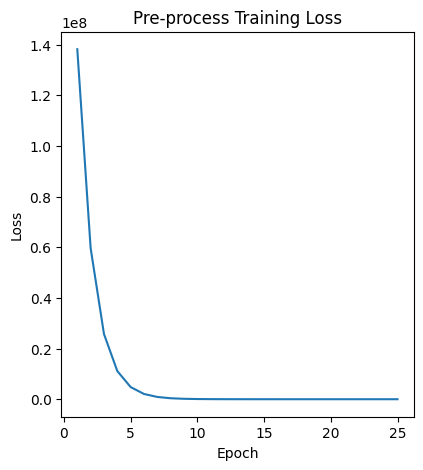

In [ ]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 25 + 1), loss_values[:25], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pre-process Training Loss')
plt.show()

In [ ]:
# Evaluate on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Make predictions on validation set
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor)
    val_loss = criterion(y_pred, y_val_tensor).item()
    
    y_pred_np = y_pred.numpy().T
    y_val_np = y_val_tensor.numpy().T
    
    corc = np.corrcoef(y_pred_np, y_val_np)
    corc = (corc + 1) / 2
    # average across rows
    electrode_corc = np.mean(corc, axis=1)
    print("accuracy per electrode: ")
    print(electrode_corc)
    overall_acc = np.mean(corc)
    
print(f"Test Error: \n Accuracy: {overall_acc:>0.4f}%, Avg loss: {val_loss:>8f} \n")

accuracy per electrode: 
[0.59821239 0.64762219 0.61734214 0.57280512 0.64983227 0.64990679
 0.64537307 0.41887121 0.64334963 0.58250406 0.39660444 0.65128125
 0.64949378 0.65799558 0.65738152 0.65727894 0.6507965  0.65465697
 0.51653187 0.59764491 0.65269095 0.61955781 0.54132001 0.65496216
 0.65750945 0.65413003 0.43230688 0.65892695 0.60972831 0.3931737
 0.65496369 0.65300858 0.65914819 0.65909323 0.65889404 0.65476705
 0.6568584  0.51152749]
Test Error: 
 Accuracy: 0.6078%, Avg loss: 28152.369141 

